### Expert Notebook: Spark processing
In this notebook, we will demonstrate some basic elements of the Spark cluster for parallel processing.

In [14]:
import datetime as dt                                     # date and time functions  
import re                                                 # to parse strings (regular expressions)
import os                                                 # operating system functions
from xml.etree import ElementTree as ET                   # XML parsing
import rasterio                                           # raster files 
import matplotlib.pyplot as mplot                         # plotting functions
from mpl_toolkits.axes_grid1 import make_axes_locatable   # more plotting functions
import seaborn as sns                                     # additional plotting tools
import glob                                               # alternative for os to search for files/directories
import numpy as np                                        # standard Python package
import matplotlib.pyplot as plt                           # standard Python plotting routine
import gdal                                               # gdal package 

In [15]:
# Routine to calculate the histogram for a given (single band) GeoTiff image file.
def histogram(image_file):
    # Open the image file
    img = gdal.Open(image_file)
    
    if img is None:
        print ('-ERROR- Unable to open image file "%s"' % image_file)
    
    # Open raster band (first band)
    raster = img.GetRasterBand(1)    
    xSize  = img.RasterXSize
    ySize  = img.RasterYSize
    print(img.GetMetadata())
    
    # Read raster data
    data = raster.ReadAsArray(0, 0, xSize, ySize)
    
    #convert DN --> real NDVI values
    data[data == 255] = np.ma.masked
    data = data * 0.004 - 0.08 #check if these are the right scale and offset factors...
        
    # Calculate histogram, let's ignore the negative NDVI values
    hist, _ = np.histogram(data, bins=25, range=(0.00, 1.00))
    hist    = (100. * hist) / np.sum(hist)
    print(hist.shape)
    
    return hist

First, we query the catalogue for Sentinel-2 10 m NDVI files and have the list printed. For now, this is done using the Python requests library. In the near futute, a Python catalogue client will be made available.

In [25]:
productName = 'urn:eop:VITO:TERRASCOPE_S2_NDVI_V2'
startDate = dt.date(2018,7,1)
endDate   = dt.date(2018,8,1)
tileId = '31UES'

# get the product list

import requests
from urllib.parse import urljoin

catalog_base_url = 'https://services.terrascope.be/catalogue/'
headers = {'Accept': 'application/json'}
payload = {
    'collection': productName,
    'tileId': tileId,
    'start': startDate.strftime('%Y-%m-%d'),
    'end': endDate.strftime('%Y-%m-%d'),
    'accessedFrom': 'MEP'
}
response = requests.get(urljoin(catalog_base_url, 'products'),
                        headers = headers,
                        params = payload)

ndviProducts = []
if response.status_code == requests.codes.ok:
    result = response.json()
    for feature in result['features']:
        ndviProducts.append(feature['properties']['links']['data'][0]['href'][7:])
    print('Found {} products:'.format(len(ndviProducts)))
    print(ndviProducts)
else:
    print(response.status_code)
    print(response.json())

Found 18 products:
['/data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2018/07/03/S2A_20180703T105621_31UES_NDVI_V200/S2A_20180703T105621_31UES_NDVI_10M_V200.tif', '/data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2018/07/07/S2A_20180707T104021_31UES_NDVI_V200/S2A_20180707T104021_31UES_NDVI_10M_V200.tif', '/data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2018/07/10/S2A_20180710T105031_31UES_NDVI_V200/S2A_20180710T105031_31UES_NDVI_10M_V200.tif', '/data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2018/07/13/S2A_20180713T105621_31UES_NDVI_V200/S2A_20180713T105621_31UES_NDVI_10M_V200.tif', '/data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2018/07/17/S2A_20180717T104021_31UES_NDVI_V200/S2A_20180717T104021_31UES_NDVI_10M_V200.tif', '/data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2018/07/20/S2A_20180720T105031_31UES_NDVI_V200/S2A_20180720T105031_31UES_NDVI_10M_V200.tif', '/data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2018/07/23/S2A_20180723T105621_31UES_NDVI_V200/S2A_20180723T105621_31UES_NDVI_10M_V200.tif', '/data/MTDA/TERRASCOPE_Sentinel2/NDVI_V2/2

{'TIFFTAG_COPYRIGHT': 'VITO', 'TIFFTAG_SOFTWARE': 'Biopar Workflow:3.0.0', 'TIFFTAG_DATETIME': '2018:07:03 10:56:21', 'AREA_OR_POINT': 'Area'}
(25,)


Text(0,0.5,'Relative frequency [%]')

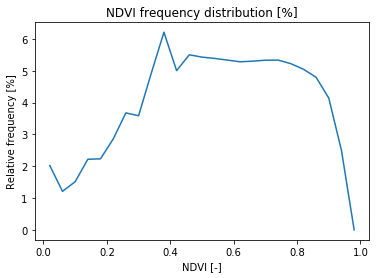

In [26]:
hist = histogram(ndviProducts[0])
mplot.title('NDVI frequency distribution [%]')

#histogram function was defined to collect the NDVI data in 25 bins within the range [0.00, 1.00]
mplot.plot(np.arange(0, np.size(hist)) * 0.04 + 0.02, hist)
mplot.xlabel('NDVI [-]')
mplot.ylabel('Relative frequency [%]')

Here we calculate a cumulative histogram for all the NDVI files in the list.

{'TIFFTAG_COPYRIGHT': 'VITO', 'TIFFTAG_SOFTWARE': 'Biopar Workflow:3.0.0', 'TIFFTAG_DATETIME': '2018:07:03 10:56:21', 'AREA_OR_POINT': 'Area'}
(25,)
{'TIFFTAG_COPYRIGHT': 'VITO', 'TIFFTAG_SOFTWARE': 'Biopar Workflow:3.0.0', 'TIFFTAG_DATETIME': '2018:07:07 10:40:21', 'AREA_OR_POINT': 'Area'}
(25,)
{'TIFFTAG_COPYRIGHT': 'VITO', 'TIFFTAG_SOFTWARE': 'Biopar Workflow:3.0.0', 'TIFFTAG_DATETIME': '2018:07:10 10:50:31', 'AREA_OR_POINT': 'Area'}
(25,)
{'TIFFTAG_COPYRIGHT': 'VITO', 'TIFFTAG_SOFTWARE': 'Biopar Workflow:3.0.0', 'TIFFTAG_DATETIME': '2018:07:13 10:56:21', 'AREA_OR_POINT': 'Area'}
(25,)
{'TIFFTAG_COPYRIGHT': 'VITO', 'TIFFTAG_SOFTWARE': 'Biopar Workflow:3.0.0', 'TIFFTAG_DATETIME': '2018:07:17 10:40:21', 'AREA_OR_POINT': 'Area'}
(25,)
{'TIFFTAG_COPYRIGHT': 'VITO', 'TIFFTAG_SOFTWARE': 'Biopar Workflow:3.0.0', 'TIFFTAG_DATETIME': '2018:07:20 10:50:31', 'AREA_OR_POINT': 'Area'}
(25,)
{'TIFFTAG_COPYRIGHT': 'VITO', 'TIFFTAG_SOFTWARE': 'Biopar Workflow:3.0.0', 'TIFFTAG_DATETIME': '2018:07:23

Text(0,0.5,'Relative frequency [%]')

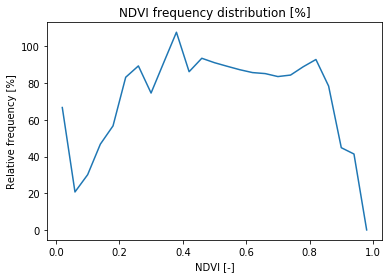

In [27]:
%%time
for i in range(0, np.size(hist)):
    hist[i]=0
for f in ndviProducts:
    hist = hist + histogram(f)

mplot.title('NDVI frequency distribution [%]')
mplot.plot(np.arange(0, np.size(hist)) * 0.04 + 0.02, hist)
mplot.xlabel('NDVI [-]')
mplot.ylabel('Relative frequency [%]')

So, this took quite some time to complete. Let's see if we can get the job done sooner if we use the SPARK cluster and do parallel processing. Of course, this is not really a representative example. The time gained will of course increase if you really have LOTS of files to process. 

To work on the processing cluster, we need to specify the resources we want:

* <b>spark.yarn.executor.memoryOverhead</b>: memory available for Python
* <b>spark.executor.cores</b>: Number of cores per executor. Usually our tasks are single threaded, so 1 is a good default.
* <b>spark.executor.memory</b>: memory to assign per executor. Memory available for Spark and Java, this can be small when most of your processing is in Python.

We set up the SparkConf with these parameters, and create a SparkContext sc, which will be our access point to the cluster.

In [28]:
from operator import add
import pyspark
import os
os.environ['PYSPARK_PYTHON']='/usr/bin/python3.5'

# Setup the Spark cluster
print( 'Configuring' ) 
conf = pyspark.SparkConf()
conf.set('spark.yarn.executor.memoryOverhead', '1g')
print( 'Memory overhead' )
conf.set('spark.executor.memory', '512mb')
print( 'Memory 512mb' )
print( 'Configuring - this may take some time' )
%time sc = pyspark.SparkContext.getOrCreate(conf=conf)

Configuring
Memory overhead
Memory 512mb
Configuring - this may take some time
CPU times: user 15.7 ms, sys: 6.5 ms, total: 22.2 ms
Wall time: 6.81 s


<div class="alert alert-block alert-warning">
Please pay attention to the second argument in this method call:
 sc.parallelize(ndviProducts,len(ndviProducts))
It specifies the number of 'partitions' that Spark has to use. Partitions can be processed in parallel, so if the number is too low, your job will take a long time to run.
In general, if the work per file is more than one second, it is safe to use as many partitions as there are files.
</div>

In [29]:
%%time

def runInSpark():
    filesRDD = sc.parallelize(ndviProducts,len(ndviProducts))

    # Apply the 'histogram' function to each filename using 'map'
    hists = filesRDD.map(histogram)

    # Combine distributed histograms into a single result
    total = list(hists.reduce(lambda h, i: map(add, h, i)))
    return total
%timeit -n1 runInSpark()

12.7 s ± 4.19 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
CPU times: user 66.9 ms, sys: 21.7 ms, total: 88.6 ms
Wall time: 1min 29s


In [30]:
total = runInSpark()

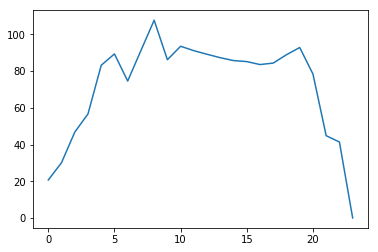

In [31]:
plt.plot(total[1:254])

In [32]:
# are the results the same?
difference = hist - total

for i in range(len(hist)):
    print( i, hist[i], total[i], difference[i] )
print( "difference:" )
print( difference )
c=0
for p in difference:
    c=c+p
if c==0:
    print("Yes, they are the same!")
else:
    print("They're not the same? How come?")

0 66.71536519070285 66.71536519070285 0.0
1 20.685111355360213 20.685111355360213 0.0
2 30.11225948565172 30.11225948565172 0.0
3 46.7357703217386 46.7357703217386 0.0
4 56.708688470001285 56.708688470001285 0.0
5 83.21151038748549 83.21151038748549 0.0
6 89.38486205057794 89.38486205057794 0.0
7 74.60780230567583 74.60780230567583 0.0
8 91.24161159781404 91.24161159781404 0.0
9 107.7468347928466 107.7468347928466 0.0
10 86.23368582828687 86.23368582828687 0.0
11 93.56060278717253 93.56060278717253 0.0
12 91.15447404792293 91.15447404792293 0.0
13 89.19691270566632 89.19691270566632 0.0
14 87.31478741914205 87.31478741914205 0.0
15 85.75823458340143 85.75823458340143 0.0
16 85.20864352631182 85.20864352631182 0.0
17 83.58887121035855 83.58887121035855 0.0
18 84.40372830917022 84.40372830917022 0.0
19 88.9479503427254 88.9479503427254 0.0
20 92.88818106911359 92.88818106911359 0.0
21 78.40922138174285 78.40922138174285 0.0
22 44.812777564120935 44.812777564120935 0.0
23 41.3721132670098

In [33]:
sc.stop()